In [66]:
import warnings

warnings.simplefilter("ignore")

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler

# Customised function to visualise classification report
from plot_classification_report import plot_classification_report as pcf 

In [2]:
# Import train data
df_train = pd.read_csv("train.csv")

df_train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [3]:
def wrangle_data(df):
    
    # Replace all NA values in the `previous_year_rating` with the most common rating: 3
    df["previous_year_rating"].fillna(3.0, inplace = True)
    
    # replace NA values in education column with most common degree
    df["education"].fillna("Bachelor's", inplace = True)
    
    # Split the strings, extract the second part of the split strings, convert the extracted part to an integer type
    df["region"] = df["region"].str.split('_').str[1].astype(int)    
    
    # Label Encoding: Encoding the degrees in an ordinal fashion
    df["education"] = df["education"].replace({"Master's & above": 2, "Bachelor's": 1,"Below Secondary":0 }).astype(int) 
    
    # Encode categorical variables
    df = pd.get_dummies(df, columns=['department', "gender", "recruitment_channel"])    
    
    return df

In [4]:
df = wrangle_data(df_train)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   employee_id                   54808 non-null  int64  
 1   region                        54808 non-null  int32  
 2   education                     54808 non-null  int32  
 3   no_of_trainings               54808 non-null  int64  
 4   age                           54808 non-null  int64  
 5   previous_year_rating          54808 non-null  float64
 6   length_of_service             54808 non-null  int64  
 7   KPIs_met >80%                 54808 non-null  int64  
 8   awards_won?                   54808 non-null  int64  
 9   avg_training_score            54808 non-null  int64  
 10  is_promoted                   54808 non-null  int64  
 11  department_Analytics          54808 non-null  uint8  
 12  department_Finance            54808 non-null  uint8  
 13  d

In [6]:
df.head()

,employee_id,region,education,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,...,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,65438,7,2,1,35,5.0,8,1,0,49,...,0,0,0,1,0,1,0,0,0,1
1,65141,22,1,1,30,5.0,4,0,0,60,...,1,0,0,0,0,0,1,1,0,0
2,7513,19,1,1,34,3.0,7,0,0,50,...,0,0,0,1,0,0,1,0,0,1
3,2542,23,1,2,39,1.0,10,0,0,50,...,0,0,0,1,0,0,1,1,0,0
4,48945,26,1,1,45,3.0,2,0,0,73,...,0,0,0,0,1,0,1,1,0,0


### Split Data

In [10]:
X = df.drop(columns = "is_promoted")
y = df["is_promoted"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (43846, 24)
X_test shape: (10962, 24)
y_train shape: (43846,)
y_test shape: (10962,)


### Resample

Since there exists a class imbalance, the dataset will be resampled

In [57]:
y_train.value_counts()

0    40086
1     3760
Name: is_promoted, dtype: int64

In [12]:
over_sampler = RandomOverSampler(random_state= 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)

### Build Model

### Baseline

Determine the baseline

In [65]:
y_train.value_counts(normalize= True).max()

0.9142453131414496

In [13]:
# Instantiate classifier
clf = RandomForestClassifier(random_state= 42)

In [16]:
# Range of hyperparameters to be used for classifier
params = {
 "n_estimators": range(25,100,25),
 "max_depth" : range(10, 50, 10)
}
params

{'n_estimators': range(25, 100, 25), 'max_depth': range(10, 50, 10)}

In [17]:
# Create a GridSearchCV object
model = GridSearchCV(
         clf,
         param_grid= params,
         cv = 5,
         n_jobs= -1, # give me all the power you have
         verbose = 1,
        )
model

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [18]:
# Fit model to oversampled data
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 50, 10),
                         'n_estimators': range(25, 100, 25)},
             verbose=1)

In [20]:
# Extract the cross-validation results from model and load them into a DataFrame named cv_results
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.599980,0.036798,0.102037,0.007265,10,25,"{'max_depth': 10, 'n_estimators': 25}",0.828001,0.827003,0.823562,0.826431,0.824872,0.825974,0.001575,11
1,5.176977,0.055917,0.186611,0.014015,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.829560,0.831307,0.824124,0.822565,0.826369,0.826785,0.003262,10
2,7.822438,0.083832,0.269789,0.009070,10,75,"{'max_depth': 10, 'n_estimators': 75}",0.824010,0.825257,0.820132,0.818885,0.823562,0.822369,0.002433,12
3,3.784747,0.020368,0.148803,0.002393,20,25,"{'max_depth': 20, 'n_estimators': 25}",0.955285,0.956657,0.949981,0.952538,0.957216,0.954336,0.002712,9
4,7.388851,0.044551,0.283245,0.001544,20,50,"{'max_depth': 20, 'n_estimators': 50}",0.958902,0.958092,0.951229,0.953786,0.957403,0.955882,0.002911,8
5,10.910612,0.083846,0.421813,0.005765,20,75,"{'max_depth': 20, 'n_estimators': 75}",0.957780,0.957094,0.952476,0.954971,0.959025,0.956269,0.002308,7
6,3.971850,0.028269,0.167065,0.002493,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.987527,0.986841,0.985281,0.986840,0.986092,0.986516,0.000767,6
7,8.165087,0.114499,0.339810,0.026906,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.990895,0.989648,0.987277,0.989148,0.988649,0.989123,0.001187,4
8,11.822668,0.103677,0.487337,0.021099,30,75,"{'max_depth': 30, 'n_estimators': 75}",0.990521,0.989710,0.987651,0.989086,0.989398,0.989273,0.000941,3
9,3.928549,0.034581,0.166694,0.000773,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.988899,0.987964,0.986716,0.988025,0.988213,0.987963,0.000707,5


In [23]:
# Extract best hyperparameters
model.best_params_

{'max_depth': 40, 'n_estimators': 50}

## Evaluate

In [26]:
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9337


In [36]:
# Save model
with open("models/model-RFC.pkl", "wb") as f:
    pickle.dump(model, f)

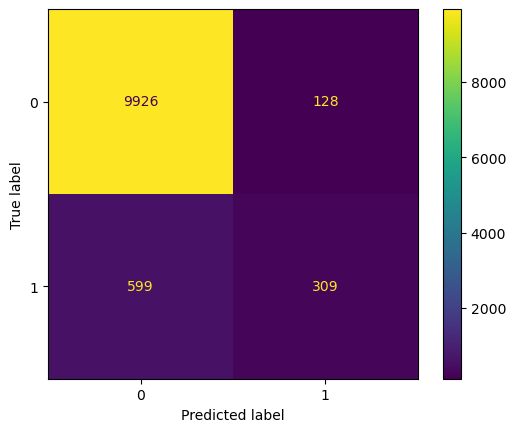

In [67]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

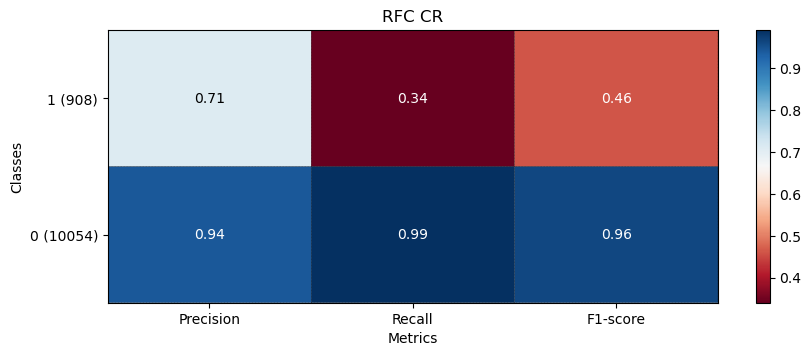

In [33]:
# Plot Classification report
class_report_over = classification_report(y_test, model.predict(X_test))
pcf(class_report_over, "RFC CR");